In [14]:
import xarray as xr
from pathlib import Path
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib import patches

import functions.eddy_feedback as ef
import functions.data_wrangling as data

# Data wrangling

### Import data

In [15]:
path = '/home/links/ct715/data_storage/isca/held-suarez'
exp_list = ['HS_T42_100y-nc', 'HS_T85_100y-nc']
# exp_list = ['HS_T42_100y_60delh-nc']

datasets = {}
for exp in exp_list:
    
    nc_path = Path(path) / exp
    nc_files = list(nc_path.glob('*.nc'))
    
    ds = xr.open_mfdataset(
        nc_files,
        parallel=True,
        chunks={'time': 360}
    )

    datasets[exp] = ds

In [16]:
datasets[exp_list[0]]

<xarray.Dataset>
Dimensions:  (time: 36000, level: 40, lat: 64, lon: 128)
Coordinates:
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * level    (level) float32 987.0 962.0 937.0 912.0 ... 87.0 62.0 37.0 9.0
  * time     (time) object 2000-01-01 12:00:00 ... 2099-12-30 12:00:00
Data variables:
    u        (time, level, lat, lon) float32 dask.array<chunksize=(360, 40, 64, 128), meta=np.ndarray>
    v        (time, level, lat, lon) float32 dask.array<chunksize=(360, 40, 64, 128), meta=np.ndarray>
    t        (time, level, lat, lon) float32 dask.array<chunksize=(360, 40, 64, 128), meta=np.ndarray>
    ubar     (time, level, lat) float32 dask.array<chunksize=(360, 40, 64), meta=np.ndarray>
    epfy     (time, level, lat) float32 dask.array<chunksize=(360, 40, 64), meta=np.ndarray>
    epfz     (time, level, lat) float64 dask.array<chunksize=(360, 40, 64), meta=np.ndarray>
    divFy    (time, level, lat) float64 dask.array<chunksize=(360, 40, 64), meta=np.ndarray>
    divFz    (time, level, lat) float64 dask.array<chunksize=(360, 40, 64), meta=np.ndarray>
Attributes:
    filename:   /home/links/ct715/data_storage/isca/HS_T42_100y/run0001/atmos...
    title:      FMS Model results
    grid_type:  regular
    grid_tile:  N/A
    comment:    pressure level interpolator, version 3.0, precision=double

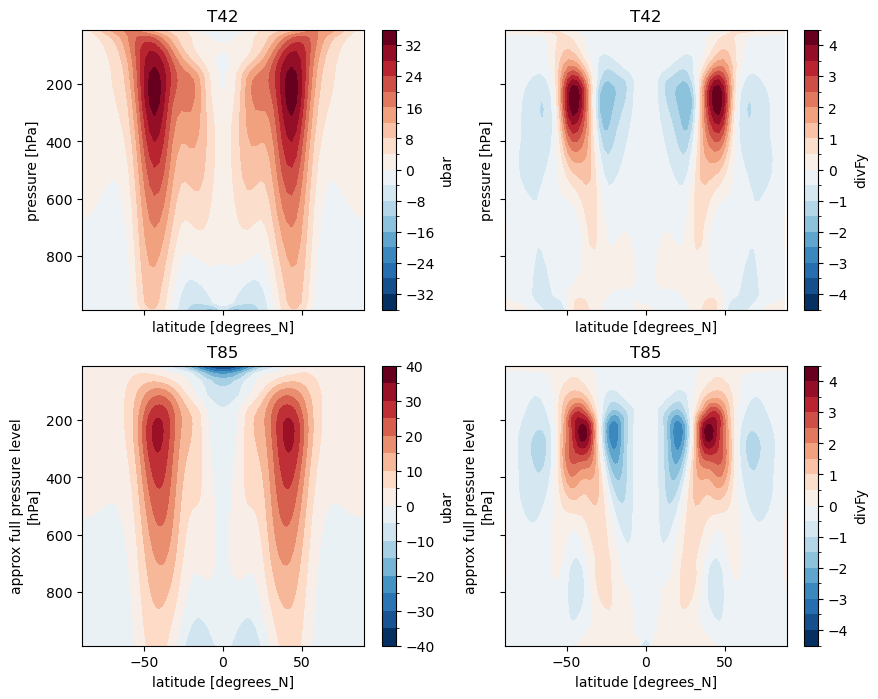

In [17]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 8), sharey=True, sharex=True)
# colour_bar = np.linspace(-5e-5, 5e-5, 21)

datasets['HS_T42_100y-nc'].mean('time').ubar.plot.contourf(levels=20, yincrease=False, ax=axes[0,0])
datasets['HS_T42_100y-nc'].mean('time').divFy.plot.contourf(levels=20, yincrease=False, ax=axes[0,1])

datasets['HS_T85_100y-nc'].mean('time').ubar.plot.contourf(levels=20, yincrease=False, ax=axes[1,0])
datasets['HS_T85_100y-nc'].mean('time').divFy.plot.contourf(levels=20, yincrease=False, ax=axes[1,1])

for ax in axes[0,:]:
    ax.set_title('T42')
for ax in axes[1,:]:
    ax.set_title('T85')

### Subsetting and calculations

In [18]:
# calculate EFP for each experiment and save to dictionary
efp_values = {}
for exp in exp_list:
    
    # calculate EFP
    efp_NH = ef.calculate_efp(datasets[exp], data_type='isca')
    efp_SH = ef.calculate_efp(datasets[exp], data_type='isca', calc_south_hemis=True)
    
    # save value into a dict of dictionaries 
    efp_values[exp] = {
        'NH': efp_NH,
        'SH': efp_SH
    }
efp_values

{'HS_T42_100y-nc': {'NH': 0.6341, 'SH': 0.5991},
 'HS_T85_100y-nc': {'NH': 0.5176, 'SH': 0.5376}}

In [19]:
# calculate djf seasonal mean
exps_djf = {}
exps_jas = {}
for exp in exp_list:
    
    # calc seasonal mean for each dataset
    djf_mean = data.seasonal_mean(datasets[exp], season='djf')
    # save to dict
    exps_djf[exp] = djf_mean
    
    # calc seasonal mean for each dataset
    jas_mean = data.seasonal_mean(datasets[exp], season='jas')
    # save to dict
    exps_jas[exp] = jas_mean

### Annual differences

In [23]:
datasets['HS_T85_100y-nc'] = datasets['HS_T85_100y-nc'].interp(lat=datasets['HS_T42_100y-nc'].lat.values)
datasets['HS_T85_100y-nc'] = datasets['HS_T85_100y-nc'].interp(lat=datasets['HS_T42_100y-nc'].level.values)

diff = datasets['HS_T85_100y-nc'].mean('time') - datasets['HS_T42_100y-nc'].mean('time')

# # subset data
diff = diff.sel(lat=slice(-85,85))
diff = diff.sel(level=slice(925., 100.))

In [24]:
diff

<xarray.Dataset>
Dimensions:  (lon: 128, level: 0, lat: 0)
Coordinates:
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * level    (level) float64 
  * lat      (lat) float64 
Data variables:
    u        (level, lat, lon) float32 dask.array<chunksize=(0, 0, 128), meta=np.ndarray>
    v        (level, lat, lon) float32 dask.array<chunksize=(0, 0, 128), meta=np.ndarray>
    t        (level, lat, lon) float32 dask.array<chunksize=(0, 0, 128), meta=np.ndarray>
    ubar     (level, lat) float32 dask.array<chunksize=(0, 0), meta=np.ndarray>
    epfy     (level, lat) float64 dask.array<chunksize=(0, 0), meta=np.ndarray>
    epfz     (level, lat) float64 dask.array<chunksize=(0, 0), meta=np.ndarray>
    divFy    (level, lat) float64 dask.array<chunksize=(0, 0), meta=np.ndarray>
    divFz    (level, lat) float64 dask.array<chunksize=(0, 0), meta=np.ndarray>

In [ ]:
break

TypeError: No numeric data to plot.

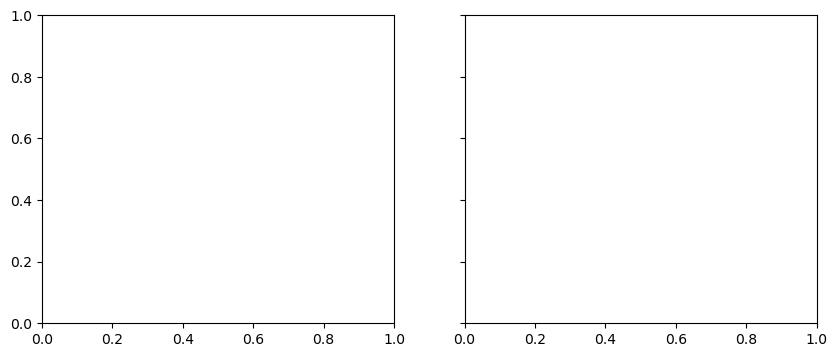

In [22]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
# colour_bar = np.linspace(-5e-5, 5e-5, 21)

diff.ubar.plot.contourf(levels=20, yincrease=False, ax=axes[0])
diff.divFy.plot.contourf(levels=20, yincrease=False, ax=axes[1])

# set titles
axes[0].set_title(f'', fontsize=16)
axes[1].set_title('')

# set axes titles
axes[0].set_xlabel('')

# plot rectangle
# Define rectangles and add them to each subplot
for ax in axes[:]:
    rect = patches.Rectangle((-75, 600.), 50, -400, fill=False, linewidth=2)
    ax.add_patch(rect)
for ax in axes[:]:
    rect = patches.Rectangle((25, 600.), 50, -400, fill=False, linewidth=2)
    ax.add_patch(rect)
    

fig.suptitle('Difference plot (T85 - T42)', fontsize=20)

plt.show()